# FEMA's National Flood Insurance Policy Database Data Exploration

### Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Imputer
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, ByteType, LongType, FloatType, ShortType
from pyspark.sql.functions import col, sum as spark_sum

### Initialize Spark Session

In [2]:
spark = SparkSession.builder \
    .config("spark.driver.memory", "10g") \
	.config("spark.executor.memory", "2g") \
    .config('spark.executor.instances', 5) \
	.config("spark.sql.debug.maxToStringFields", "100")\
    .appName("Flood Data") \
	.getOrCreate()

24/05/18 13:36:13 WARN Utils: Your hostname, MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.109 instead (on interface en0)
24/05/18 13:36:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/18 13:36:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Load data to Spark dataframe; Infer Schema

In [3]:
#path to data 
data_path = "./NFIP/nfip-flood-policies.csv"

df = spark.read.option("header","true").option("inferSchema","true").csv(data_path)

## Perform the Data Exploration
Below is the outline of the Data Exploration Section:
- Print Schema
- Column Description
- Display the Number of Variables (Columnns)
- Show the First Few Rows
- Display Number of Observations
- Missing Values in the Dataframe
- Statistics Summary and Data Distribution
- Correlations Among Variables
- Scatterplots

### Print Schema

Understanding the structure of data (column names and types) is crucial.

In [4]:
df.printSchema()

root
 |-- agriculturestructureindicator: string (nullable = true)
 |-- basefloodelevation: double (nullable = true)
 |-- basementenclosurecrawlspacetype: integer (nullable = true)
 |-- cancellationdateoffloodpolicy: date (nullable = true)
 |-- censustract: long (nullable = true)
 |-- condominiumindicator: string (nullable = true)
 |-- construction: string (nullable = true)
 |-- countycode: integer (nullable = true)
 |-- crsdiscount: double (nullable = true)
 |-- deductibleamountinbuildingcoverage: string (nullable = true)
 |-- deductibleamountincontentscoverage: string (nullable = true)
 |-- elevatedbuildingindicator: string (nullable = true)
 |-- elevationcertificateindicator: string (nullable = true)
 |-- elevationdifference: integer (nullable = true)
 |-- federalpolicyfee: integer (nullable = true)
 |-- floodzone: string (nullable = true)
 |-- hfiaasurcharge: integer (nullable = true)
 |-- houseofworshipindicator: string (nullable = true)
 |-- latitude: double (nullable = true)
 |--

### Column Description

**Description of the columns from the FEMA's National Flood Insurance Policy Database, grouped by their data types and purpose:**

**Geographic and Location Details**
- **censustract (long):** Census tract number indicating the specific area where the property is located, used for demographic analysis.
- **countycode (integer):** Numeric code representing the county in which the property is insured.
- **floodzone (string):** Designation of the flood zone according to FEMA's mapping, crucial for assessing the property's flood risk.
- **latitude (double), longitude (double):** Geographic coordinates specifying the precise location of the property.
- **propertystate (string):** The U.S. state where the property is located.
- **reportedcity (string):** The city reported for the insured property.
- **reportedzipcode (integer):** Zip code where the property is situated, used for localizing insurance coverage and risk.

**Property and Construction Details**
- **agriculturestructureindicator (string):** Indicates whether the property is used for agricultural purposes.
- **basementenclosurecrawlspacetype (integer):** Type of basement or crawlspace present at the property, affecting flood risk assessment.
- **construction (string):** Describes the type of construction materials and methods used, which can affect the property's vulnerability to flood damage.
- **numberoffloorsininsuredbuilding (integer):** Total floors in the insured building, important for determining potential flood damage and insurance coverage needs.
- **elevatedbuildingindicator (string):** Indicates whether the building is elevated, a key factor in reducing flood risk.

**Policy Details**
- **policycost (integer):** The total cost of the flood insurance policy.
- **policycount (integer):** The number of policies associated with a single property or account.
- **policyeffectivedate (date), policyterminationdate (date):** Start and end dates of the flood insurance coverage.
- **totalbuildinginsurancecoverage (integer), totalcontentsinsurancecoverage (integer):** The amount of insurance coverage for the building and its contents, respectively.
- **totalinsurancepremiumofthepolicy (integer):** Total premium amount for the flood insurance policy.

**Flood Risk Assessment Specifics**
- **basefloodelevation (double):** The base flood elevation expected for a particular area, critical for understanding flood risk levels.
- **elevationcertificateindicator (string), elevationdifference (integer):** Presence of an elevation certificate and the difference in elevation, respectively, both crucial for assessing compliance with floodplain management.
- **lowestadjacentgrade (double), lowestfloorelevation (double):** Measures of elevation that help determine the property's flood exposure.

**Insurance Policy Features**
- **crsdiscount (double):** Community Rating System discount applied to the policy, which can reduce insurance premiums based on community flood preparedness.
- **deductibleamountinbuildingcoverage (integer), deductibleamountincontentscoverage (integer):** Deductible amounts for building and contents coverage, influencing out-of-pocket costs after a flood.
- **hfiaasurcharge (integer):** Surcharge applied under the Homeowner Flood Insurance Affordability Act.
- **federalpolicyfee (integer):** A fee associated with the federal policy governing flood insurance.

**Special Indicators**
- **condominiumindicator (string), primaryresidenceindicator (string):** Indicate whether the insured property is a condominium or the primary residence of the owner.
- **houseofworshipindicator (string), nonprofitindicator (string):** Indicators of whether the property is used as a house of worship or is owned by a nonprofit organization, affecting policy terms and possibly qualifying for special considerations.
- **postfirmconstructionindicator (string):** Indicates if the building was constructed after the community's first Flood Insurance Rate Map was issued, which can affect insurance rates.
- **smallbusinessindicatorbuilding (string):** Indicates whether the insured building is used for small business purposes.

**Additional Policy and Coverage Information**
- **originalconstructiondate (date), originalnbdate (date):** Dates of original construction and the building's initial notebook entry, important for historical property assessments.
- **cancellationdateoffloodpolicy (date):** Date when the flood policy was cancelled, if applicable.
- **regularemergencyprogramindicator (string):** Indicates the type of FEMA program under which the policy is covered, distinguishing between regular and emergency management programs.
- **ratemethod (integer):** Describes the method used to calculate the insurance rate, impacting how premiums are determined.
- **locationofcontents (string):** Specifies where within the property the insured contents are located, relevant for claims and risk assessments.

### Display number of Variables (Columns)


In [5]:
num_variables = len(df.columns)
print("Number of Columns:", num_variables)

Number of Columns: 45


### Show the First Few Rows

In [6]:
df.show(5,vertical=True)

-RECORD 0--------------------------------------------------
 agriculturestructureindicator      | NULL                 
 basefloodelevation                 | NULL                 
 basementenclosurecrawlspacetype    | 2                    
 cancellationdateoffloodpolicy      | NULL                 
 censustract                        | 33013038500          
 condominiumindicator               | N                    
 construction                       | N                    
 countycode                         | 33013                
 crsdiscount                        | 0.0                  
 deductibleamountinbuildingcoverage | 0                    
 deductibleamountincontentscoverage | 0                    
 elevatedbuildingindicator          | N                    
 elevationcertificateindicator      | NULL                 
 elevationdifference                | 999                  
 federalpolicyfee                   | 13                   
 floodzone                          | X 

### Display Number of Observations

In [7]:
df.count()

50406943

FEMA's National Flood Insurance Policy Database, containing over 50 million (50,406,943) policy transactions.

### Missing Values in the Dataframe

In [8]:
#find number of missing values in the dataframe
missing_vals = df.select(*(spark_sum(col(i).isNull().cast("int")).alias(i) for i in df.columns))

In [9]:
missing_vals.show(vertical= True)

-RECORD 0--------------------------------------
 agriculturestructureindicator      | 38923313 
 basefloodelevation                 | 33636759 
 basementenclosurecrawlspacetype    | 802      
 cancellationdateoffloodpolicy      | 43614057 
 censustract                        | 467119   
 condominiumindicator               | 6        
 construction                       | 13       
 countycode                         | 48999    
 crsdiscount                        | 0        
 deductibleamountinbuildingcoverage | 661993   
 deductibleamountincontentscoverage | 5561584  
 elevatedbuildingindicator          | 258      
 elevationcertificateindicator      | 32606397 
 elevationdifference                | 0        
 federalpolicyfee                   | 0        
 floodzone                          | 169145   
 hfiaasurcharge                     | 0        
 houseofworshipindicator            | 34476251 
 latitude                           | 338699   
 locationofcontents                 | 15

**Here's a description of the missing value situation in the FEMA Flood Insurance Policy Database:** 

1. **High Missing Values:**
- **Base Flood Elevation, Latitude, Longitude, Lowest Adjacent Grade, Lowest Floor Elevation:** These fields each have around 50,406,943 missing values. This suggests a significant lack of geographic and elevation data, which are critical in flood insurance calculations.
- **Elevation Certificate Indicator, Elevation Difference:** Both fields are missing approximately 32,806,397 and 32,897,994 values respectively, indicating that elevation certificates, which are vital for verifying compliance with floodplain management regulations, are largely absent.
- **Obstruction Type:** Missing around 40,793,526 values, indicating that details about obstructions which can affect flood risk assessments are predominantly not reported.
- **House of Worship Indicator, Nonprofit Indicator:** Each has over 34,476,251 and 34,493,094 missing entries respectively, indicating a lack of identification of these property types, which might have different considerations in policy terms.

2. **Moderate Missing Values:**
- **Deductible Amount in Building Coverage, Deductible Amount in Contents Coverage:** Missing 15,649,149 and 18,265,104 values respectively, which implies incomplete data on policy deductibles that could affect premium calculations and risk assessments.
- **Location of Contents:** With 15,389,767 missing entries, there's substantial missing information on where contents are located within the insured buildings, which is vital for damage assessments.

3. **Low Missing Values:**
- **Census Tract, Flood Zone:** Missing 467,119 and 169,145 entries respectively. Although relatively lower, these still represent significant gaps, especially as these fields are crucial for location-specific risk assessment.
- **Number of Floors in Insured Building:** Missing data on 162,301 entries could affect understanding building structure and associated risk.

4. **Minimal to No Missing Values:**
- Fields like **CRS Discount, Federal Policy Fee**, and various policy-related dates (effectiveness, termination) and costs show zero missing values, indicating complete data in terms of policy transaction details.
- Similarly, **County Code, Construction, Condominium Indicator, Occupancy Type** show minimal missing data (under 50,000), suggesting good coverage of basic property and policyholder information.

Overall, the dataset shows a strong presence of policy and basic property information but suffers from a significant absence of detailed geographic and structural data. This gap in data can hamper effective risk assessment and pricing of flood insurance policies, especially in areas prone to flooding where such data is most critical. Addressing these missing values, either by data imputation where appropriate or by collecting missing data, could significantly enhance the robustness of any analysis or predictive modeling based on this dataset.

### Statistics Summary and Data Distribution

In [10]:
numerical_columns = [col_name for col_name, data_type in df.dtypes if data_type in ["int", "bigint", "double"]]

# Select only numerical columns
numerical_df = df.select(*numerical_columns)

# Generate summary statistics
summary_stats = numerical_df.describe()

# Show summary statistics
summary_stats.show(vertical = True)

24/05/18 13:48:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0------------------------------------------------
 summary                          | count                
 basefloodelevation               | 16770184             
 basementenclosurecrawlspacetype  | 50406141             
 censustract                      | 49939824             
 countycode                       | 50357944             
 crsdiscount                      | 50406943             
 elevationdifference              | 50406943             
 federalpolicyfee                 | 50406943             
 hfiaasurcharge                   | 50406943             
 latitude                         | 50068244             
 longitude                        | 50068244             
 lowestadjacentgrade              | 15466364             
 lowestfloorelevation             | 17346341             
 numberoffloorsininsuredbuilding  | 50244642             
 occupancytype                    | 50406937             
 policycost                       | 50406943             
 policycount  

The summary statistics for the FEMA National Flood Insurance Policy Database provide a comprehensive overview of various policy and property-related numerical attributes. These statistics include measures of central tendency, dispersion, and range, all of which are critical for understanding the distribution and potential data quality issues within the dataset. Below is a detailed analysis of the key statistical summaries:

**Central Tendency and Dispersion**
1. **Base Flood Elevation:**
- Average (Mean): 119.47 ft.
- Standard Deviation: 522.49 ft.
- Range: -9999 - 85,640 ft.
2. **Lowest Adjacent Grade:**
- Average (Mean): 129.20 ft.
- Standard Deviation: 609.92 ft.
- Range: -9,999 - 99,990.9 ft.
3. **Lowest Floor Elevation:**
- Average (Mean): 385.62 ft.
- Standard Deviation: 1,676.42 ft.
- Range: -9,997.9 - 99,989 ft.
4. **Basement Enclosure Crawl Space Type:**
- Average (Mean): 0.37, indicating a slight bias towards lower classifications.
- Standard Deviation: 0.86, showing moderate variability within the data.
- Range: Min 0 to Max 4, spanning several classification levels.
5. **Census Tract:**
- Average (Mean): Approximately 2.6 x 10¹⁰.
- Standard Deviation: About 1.58 x 10¹⁰, suggesting a wide spread across census tracts.
6. **CRS Discount:**
- Average: 0.064, typically low across the dataset.
- Standard Deviation: 0.091, with most data points close to zero but some higher values.
7. **Deductible Amount in Building and Contents Coverage:**
- Building Coverage Average: 1.66 with a deviation of 1.46.
- Contents Coverage Average: 0.98 with a deviation of 1.05.
- Both show low average deductible amounts but with notable variation.
8. **Elevation Difference:**
- Average: 1.69, indicating minor differences in elevation on average.
- Standard Deviation: 3.39, suggesting significant outliers affecting the elevation difference.
9. **Policy Related Figures (Policy Cost, Policy Count, Total Insurance Coverage, etc.):**
- These values have a high mean and standard deviation, indicating a significant spread in the policy costs and coverages, reflecting diverse insurance policies and property valuations.

**Extremes (Minimum and Maximum Values)**
- Notable minimums include negative values in **Federal Policy Fee and HFIAA Surcharge**, possibly indicating refunds or adjustments.
- The maximum values in **Total Building Insurance Coverage and Total Insurance Premium of the Policy** reach into the hundreds of millions, highlighting cases with exceptionally high insurance coverage.

**Implications**
The substantial missing data in critical geographical and elevation columns could significantly hinder risk assessment accuracy. The wide variability in policy costs and coverage levels underscores the diverse nature of the insured properties. Accurate and complete data in these fields are crucial for effective risk management and policy pricing in flood insurance.

This analysis provides a basis for further data cleaning, particularly in addressing missing values and outliers, which are essential for improving data quality and the reliability of subsequent analyses and decision-making processes based on this dataset.

### Correlations Among Variables

In [11]:
numerical_df.show(5,vertical=True)

-RECORD 0---------------------------------------
 basefloodelevation               | NULL        
 basementenclosurecrawlspacetype  | 2           
 censustract                      | 33013038500 
 countycode                       | 33013       
 crsdiscount                      | 0.0         
 elevationdifference              | 999         
 federalpolicyfee                 | 13          
 hfiaasurcharge                   | 0           
 latitude                         | 43.3        
 longitude                        | -71.8       
 lowestadjacentgrade              | NULL        
 lowestfloorelevation             | NULL        
 numberoffloorsininsuredbuilding  | 2           
 occupancytype                    | 1           
 policycost                       | 388         
 policycount                      | 1           
 policytermindicator              | 1           
 totalbuildinginsurancecoverage   | 250000      
 totalcontentsinsurancecoverage   | 100000      
 totalinsurancepremi

In [12]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Imputer

v_col = "features"
input = numerical_df.columns
output = [v_col + str(i) for i in range(len(input))]
imputer = Imputer(strategy='mean',inputCols=input,outputCols=output)
changed_df = imputer.fit(numerical_df).transform(numerical_df) 

assembler = VectorAssembler(inputCols=output,outputCol=v_col)
numerical_df_vector = assembler.transform(changed_df).select(v_col)
numerical_df_vector

DataFrame[features: vector]

In [13]:
matrix = Correlation.corr(numerical_df_vector,v_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist()
print(corr_matrix)

24/05/18 13:59:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


[[1.0, 0.05835923233138656, 0.045348715060230874, 0.04452366797155512, -0.10226921108097828, 7.47005824308675e-05, -0.010387177126363122, 0.014284015128349729, 0.12638383851377266, -0.13551456752425814, 0.8181030501174288, 0.3047834007873046, 0.02123204991850198, 0.039488213849563546, -0.0017586364749227323, -0.008273477372144566, -1.657059310784373e-05, -0.00797478163619458, -0.03432244037265909, -0.002348467821387103], [0.05835923233138656, 1.0, 0.13623903586845487, 0.1322243889691115, -0.1337456840142641, 0.04144637455805757, 0.021515636223077703, 0.039205129679828934, 0.4322749154690187, 0.10160449532374956, 0.05012914035133893, -0.014776239600981919, 0.4205917981132783, -0.06389760287441462, 0.07213744564440353, 0.008797902979000462, -0.02450568557810686, 0.0069468869987788255, -0.09892408517021709, 0.0693259281247627], [0.045348715060230874, 0.13623903586845487, 1.0, 0.9861052821687084, -0.23633772590850227, 0.1406429179696707, -0.04651095355139786, -0.001706502567808515, 0.27126

In [14]:
numerical_df.columns

['basefloodelevation',
 'basementenclosurecrawlspacetype',
 'censustract',
 'countycode',
 'crsdiscount',
 'elevationdifference',
 'federalpolicyfee',
 'hfiaasurcharge',
 'latitude',
 'longitude',
 'lowestadjacentgrade',
 'lowestfloorelevation',
 'numberoffloorsininsuredbuilding',
 'occupancytype',
 'policycost',
 'policycount',
 'policytermindicator',
 'totalbuildinginsurancecoverage',
 'totalcontentsinsurancecoverage',
 'totalinsurancepremiumofthepolicy']

In [15]:
columns = ['basefloodelevation',
 'basementenclosurecrawlspacetype',
 'censustract',
 'countycode',
 'crsdiscount',
 'elevationdifference',
 'federalpolicyfee',
 'hfiaasurcharge',
 'latitude',
 'longitude',
 'lowestadjacentgrade',
 'lowestfloorelevation',
 'numberoffloorsininsuredbuilding',
 'occupancytype',
 'policycost',
 'policycount',
 'policytermindicator',
 'totalbuildinginsurancecoverage',
 'totalcontentsinsurancecoverage',
 'totalinsurancepremiumofthepolicy']
df_c = spark.createDataFrame(corr_matrix,columns)

In [16]:
df_c.select('basefloodelevation',
 'basementenclosurecrawlspacetype',
 'censustract').show(20)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py:154: DeprecationWarning: This process (pid=76364) is multi-threaded, use of fork() may lead to deadlocks in the child.


+--------------------+-------------------------------+--------------------+
|  basefloodelevation|basementenclosurecrawlspacetype|         censustract|
+--------------------+-------------------------------+--------------------+
|                 1.0|            0.05835923233138656|0.045348715060230874|
| 0.05835923233138656|                            1.0| 0.13623903586845487|
|0.045348715060230874|            0.13623903586845487|                 1.0|
| 0.04452366797155512|             0.1322243889691115|  0.9861052821687084|
|-0.10226921108097828|            -0.1337456840142641|-0.23633772590850227|
| 7.47005824308675E-5|            0.04144637455805757|  0.1406429179696707|
|-0.01038717712636...|           0.021515636223077703|-0.04651095355139786|
|0.014284015128349729|           0.039205129679828934|-0.00170650256780...|
| 0.12638383851377266|             0.4322749154690187| 0.27126939137487294|
|-0.13551456752425814|            0.10160449532374956|0.038693021361980766|
|  0.8181030

In [17]:
df_c.select('countycode',
 'crsdiscount',
 'elevationdifference').show(20)

+--------------------+--------------------+--------------------+
|          countycode|         crsdiscount| elevationdifference|
+--------------------+--------------------+--------------------+
| 0.04452366797155512|-0.10226921108097828| 7.47005824308675E-5|
|  0.1322243889691115| -0.1337456840142641| 0.04144637455805757|
|  0.9861052821687084|-0.23633772590850227|  0.1406429179696707|
|                 1.0|-0.23953380471436234| 0.13888862687868733|
|-0.23953380471436234|                 1.0| -0.5259678054689083|
| 0.13888862687868733| -0.5259678054689083|                 1.0|
|-0.04591061242264458| 0.12618095833291212|-0.12308129153346879|
|-0.00380940314362...|0.048954413784206216|-0.04971959541878701|
| 0.25085012346550845|-0.27508558815552225|  0.1959940803211799|
| 0.04963240625202706| 0.12376428198089964|-0.14955971097407328|
|0.034103610284641726|-0.08582096552979489|0.002425271072278...|
|-6.80664449099431...|-0.00575452231836...|0.005525565608556751|
| 0.12667043463679634|-0.

In [18]:
df_c.select('federalpolicyfee',
 'hfiaasurcharge',
 'latitude').show(20)

+--------------------+--------------------+--------------------+
|    federalpolicyfee|      hfiaasurcharge|            latitude|
+--------------------+--------------------+--------------------+
|-0.01038717712636...|0.014284015128349729| 0.12638383851377266|
|0.021515636223077703|0.039205129679828934|  0.4322749154690187|
|-0.04651095355139786|-0.00170650256780...| 0.27126939137487294|
|-0.04591061242264458|-0.00380940314362...| 0.25085012346550845|
| 0.12618095833291212|0.048954413784206216|-0.27508558815552225|
|-0.12308129153346879|-0.04971959541878701|  0.1959940803211799|
|                 1.0| 0.15998037490116276|-0.02569128904685...|
| 0.15998037490116276|                 1.0| 0.04994652724067962|
|-0.02569128904685...| 0.04994652724067962|                 1.0|
| 0.03643340484637455|0.011012441102289104|-0.10822625068224143|
|-0.00935471628409477|0.011091913551252466| 0.10842310185825517|
|-0.01125795805632...|-0.01874631398887634| 0.01787552000870374|
| 0.10729663798512859|0.0

In [19]:
df_c.select('longitude',
 'lowestadjacentgrade',
 'lowestfloorelevation').show(20)

+--------------------+--------------------+--------------------+
|           longitude| lowestadjacentgrade|lowestfloorelevation|
+--------------------+--------------------+--------------------+
|-0.13551456752425814|  0.8181030501174288|  0.3047834007873046|
| 0.10160449532374956| 0.05012914035133893|-0.01477623960098...|
|0.038693021361980766|0.034632614969485595|1.374835906710930...|
| 0.04963240625202706|0.034103610284641726|-6.80664449099431...|
| 0.12376428198089964|-0.08582096552979489|-0.00575452231836...|
|-0.14955971097407328|0.002425271072278...|0.005525565608556751|
| 0.03643340484637455|-0.00935471628409477|-0.01125795805632...|
|0.011012441102289104|0.011091913551252466|-0.01874631398887634|
|-0.10822625068224143| 0.10842310185825517| 0.01787552000870374|
|                 1.0|-0.12337700047640358|-0.04205996452248668|
|-0.12337700047640358|                 1.0|  0.2693569000679416|
|-0.04205996452248668|  0.2693569000679416|                 1.0|
| 0.12763844942700278| 0.

In [20]:
df_c.select('numberoffloorsininsuredbuilding',
 'occupancytype',
 'policycost').show(20)

+-------------------------------+--------------------+--------------------+
|numberoffloorsininsuredbuilding|       occupancytype|          policycost|
+-------------------------------+--------------------+--------------------+
|            0.02123204991850198|0.039488213849563546|-0.00175863647492...|
|             0.4205917981132783|-0.06389760287441462| 0.07213744564440353|
|            0.13092070392149213|-0.02151854477004...|-0.00940672579516...|
|            0.12667043463679634|-0.02083336431546968|-0.01020270930151...|
|           -0.06978076159056372| 0.04701164748485697| 0.06739894183937774|
|           -0.02959368105409...|-0.05068082979967146|6.468266631659089E-4|
|            0.10729663798512859| 0.14237367075146548|  0.3864721337330112|
|           0.056225567874606905| 0.30145575938946867|  0.1823519286217399|
|             0.3437598815781546| 0.03707897744013738| 0.06080599667465571|
|            0.12763844942700278|-0.00248049165686...|0.025262116267291728|
|           

In [21]:
df_c.select('policycount',
 'policytermindicator',
 'totalbuildinginsurancecoverage').show(20)

+--------------------+--------------------+------------------------------+
|         policycount| policytermindicator|totalbuildinginsurancecoverage|
+--------------------+--------------------+------------------------------+
|-0.00827347737214...|-1.65705931078437...|          -0.00797478163619458|
|0.008797902979000462|-0.02450568557810686|          0.006946886998778...|
|-0.02354252110006475|0.035625079186622007|          -0.02664276057268567|
|-0.02335026782739591| 0.04136907348096719|          -0.02736003235722579|
| 0.02814710877178118|-0.03970568654901237|          0.025212129977885484|
|-0.03065010725766...| 0.04104422570965059|          -0.03866066385828...|
|  0.5481074038104509|-0.02839057493420286|           0.49635660866817927|
|  0.0319498731974377|-0.02571907189115...|          0.038710982066891025|
|-0.02512727932134...|0.001390069725837...|          -0.02446116456239...|
| 0.01019871929455973|0.005318202524779167|          0.007148866689062665|
|-0.00739083457659...|-1.

In [22]:
df_c.select('totalcontentsinsurancecoverage',
 'totalinsurancepremiumofthepolicy').show(20)

+------------------------------+--------------------------------+
|totalcontentsinsurancecoverage|totalinsurancepremiumofthepolicy|
+------------------------------+--------------------------------+
|          -0.03432244037265909|            -0.00234846782138...|
|          -0.09892408517021709|              0.0693259281247627|
|          0.014045383330901542|            -0.00788805859775...|
|          0.008361075386161234|            -0.00851191616326...|
|           -0.1443948051727502|             0.05863870325056883|
|           0.11507960281910591|            0.009922795564581026|
|          -0.09552873635534823|              0.3359488202322962|
|          0.014049042681092588|             0.11148432510815016|
|          -0.10442024470081232|             0.06066938471879821|
|          -0.00173734949061...|            0.023512821648468796|
|          -0.03205674352377111|            -0.00295009384701...|
|          -0.00959618414729...|            -0.01006926417078...|
|         

The dataframe new_df is the dataframe with the imputed mean values and this code checks that there are zero missing values and the column names are changed from feature0, feature1 and so on to the original column names within the new_df dataframe.

In [23]:
new_df = changed_df.drop('basefloodelevation',
 'basementenclosurecrawlspacetype',
 'censustract',
 'countycode',
 'crsdiscount',
 'elevationdifference',
 'federalpolicyfee',
 'hfiaasurcharge',
 'latitude',
 'longitude',
 'lowestadjacentgrade',
 'lowestfloorelevation',
 'numberoffloorsininsuredbuilding',
 'occupancytype',
 'policycost',
 'policycount',
 'policytermindicator',
 'totalbuildinginsurancecoverage',
 'totalcontentsinsurancecoverage',
 'totalinsurancepremiumofthepolicy')
new_df.show(5,vertical=True)

-RECORD 0------------------------
 features0  | 119.46875184553842 
 features1  | 2                  
 features2  | 33013038500        
 features3  | 33013              
 features4  | 0.0                
 features5  | 999                
 features6  | 13                 
 features7  | 0                  
 features8  | 43.3               
 features9  | -71.8              
 features10 | 129.1970600006573  
 features11 | 385.6220114835789  
 features12 | 2                  
 features13 | 1                  
 features14 | 388                
 features15 | 1                  
 features16 | 1                  
 features17 | 250000             
 features18 | 100000             
 features19 | 375                
-RECORD 1------------------------
 features0  | 119.46875184553842 
 features1  | 0                  
 features2  | 22063040700        
 features3  | 22063              
 features4  | 0.05               
 features5  | 999                
 features6  | 35                 
 features7  | 

In [24]:
new_df_missing_vals = new_df.select(*(spark_sum(col(i).isNull().cast("int")).alias(i) for i in new_df.columns))

In [25]:
new_df_missing_vals.show(vertical= True)

-RECORD 0---------
 features0  | 0   
 features1  | 0   
 features2  | 0   
 features3  | 0   
 features4  | 0   
 features5  | 0   
 features6  | 0   
 features7  | 0   
 features8  | 0   
 features9  | 0   
 features10 | 0   
 features11 | 0   
 features12 | 0   
 features13 | 0   
 features14 | 0   
 features15 | 0   
 features16 | 0   
 features17 | 0   
 features18 | 0   
 features19 | 0   



In [26]:
column_names = ['basefloodelevation',
 'basementenclosurecrawlspacetype',
 'censustract',
 'countycode',
 'crsdiscount',
 'elevationdifference',
 'federalpolicyfee',
 'hfiaasurcharge',
 'latitude',
 'longitude',
 'lowestadjacentgrade',
 'lowestfloorelevation',
 'numberoffloorsininsuredbuilding',
 'occupancytype',
 'policycost',
 'policycount',
 'policytermindicator',
 'totalbuildinginsurancecoverage',
 'totalcontentsinsurancecoverage',
 'totalinsurancepremiumofthepolicy']
new_df = new_df.toDF(*column_names)
new_df.show(5,vertical=True)

-RECORD 0----------------------------------------------
 basefloodelevation               | 119.46875184553842 
 basementenclosurecrawlspacetype  | 2                  
 censustract                      | 33013038500        
 countycode                       | 33013              
 crsdiscount                      | 0.0                
 elevationdifference              | 999                
 federalpolicyfee                 | 13                 
 hfiaasurcharge                   | 0                  
 latitude                         | 43.3               
 longitude                        | -71.8              
 lowestadjacentgrade              | 129.1970600006573  
 lowestfloorelevation             | 385.6220114835789  
 numberoffloorsininsuredbuilding  | 2                  
 occupancytype                    | 1                  
 policycost                       | 388                
 policycount                      | 1                  
 policytermindicator              | 1           

In [ ]:
print(new_df.dtypes)

In [27]:
# Milestone 3: Construct Linear Regression model to perform Feature Importance (find weights of features, choose top weights' features to keep)
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# creating train and test sets
# X = new_df.drop('totalinsurancepremiumofthepolicy')
# y = df['totalinsurancepremiumofthepolicy']
# ASK: Is 'features' correct?
assembler = VectorAssembler(
    inputCols=['basefloodelevation',
 'basementenclosurecrawlspacetype',
 'censustract',
 'countycode',
 'crsdiscount',
 'elevationdifference',
 'federalpolicyfee',
 'hfiaasurcharge',
 'latitude',
 'longitude',
 'lowestadjacentgrade',
 'lowestfloorelevation',
 'numberoffloorsininsuredbuilding',
 'occupancytype',
 'policycost',
 'policycount',
 'policytermindicator',
 'totalbuildinginsurancecoverage',
 'totalcontentsinsurancecoverage'],
    outputCol = 'features')
new_df = assembler.transform(new_df)
final_data = new_df.select('features', 'totalinsurancepremiumofthepolicy')

train_data, test_data = final_data.randomSplit([0.7, 0.3], seed=42)

lr = LinearRegression(featuresCol = 'features', labelCol = 'totalinsurancepremiumofthepolicy', predictionCol = 'predicted_premium', regParam = 0.3)
lr_model = lr.fit(train_data)

24/05/18 14:12:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [30]:
# Milestone 3: Print coefficients of the features (will run this cell AFTER LinReg is successful)
coefficients = lr_model.coefficients
print("Coefficients: {}".format(lr_model.coefficients)) 

Coefficients: [-0.00034366225982977635,-2.7028946217449725,-3.1266371101567534e-10,0.0002019688552190376,-28.575181212933426,-0.0035443198285837734,-1.1482714371068048,-1.4080199041381358,0.2798427203465946,0.050257400092184636,-0.0010169937528706962,-0.00041071919113262604,0.9157052648291584,3.9822580516652923,0.9342110367211144,3.9676070450583514,7.069634236455279,-1.444796450243043e-05,-1.3433801266528344e-05]


In [31]:
# Milestone 3: Construct Feature Importance to find top 10 features to choose to represent our dataset.
feature_importance = sorted(list(zip(new_df.columns[:-1], map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

Feature Importance:
  crsdiscount: 28.575
  policytermindicator: 7.070
  occupancytype: 3.982
  policycount: 3.968
  basementenclosurecrawlspacetype: 2.703
  hfiaasurcharge: 1.408
  federalpolicyfee: 1.148
  policycost: 0.934
  numberoffloorsininsuredbuilding: 0.916
  latitude: 0.280
  longitude: 0.050
  elevationdifference: 0.004
  lowestadjacentgrade: 0.001
  lowestfloorelevation: 0.000
  basefloodelevation: 0.000
  countycode: 0.000
  totalbuildinginsurancecoverage: 0.000
  totalcontentsinsurancecoverage: 0.000
  censustract: 0.000


In [34]:
# Milestone 3: Construct Linear Regression prediction model with the new Chosen 10 Features
assembler_2 = VectorAssembler(
    inputCols=['basementenclosurecrawlspacetype',
 'crsdiscount',
 'federalpolicyfee',
 'hfiaasurcharge',
 'latitude',
 'numberoffloorsininsuredbuilding',
 'occupancytype',
 'policycost',
 'policycount',
 'policytermindicator'],
    outputCol = 'predict_features')

new_df = assembler_2.transform(new_df)

new_final_data = new_df.select('predict_features', 'totalinsurancepremiumofthepolicy')
train_data, test_data = new_final_data.randomSplit([0.7, 0.3], seed=42)

lr_2 = LinearRegression(featuresCol = 'predict_features', labelCol = 'totalinsurancepremiumofthepolicy', predictionCol = 'predicted_premium_stats', regParam = 0.3)
lr_model_2 = lr_2.fit(train_data)

In [36]:
# Milestone 3: Get Training data RMSE for Model
# RMSE ranges from 0 to infinity, lower RMSE the better, (higher weight to larger errors)
from pyspark.ml.evaluation import RegressionEvaluator
predictions_rmse_train = lr_model_2.transform(train_data)

evaluator = RegressionEvaluator(labelCol = 'totalinsurancepremiumofthepolicy', predictionCol = 'predicted_premium_stats', metricName = 'rmse')
rmse_train = evaluator.evaluate(predictions_rmse_train)
print("Root Mean Squared Error (RMSE) on train data: {:.3f}".format(rmse_train))

Root Mean Squared Error (RMSE) on train data: 118.133


In [37]:
# Milestone 3: Get Training data R-squared for Model
evaluator_r2 = RegressionEvaluator(labelCol='totalinsurancepremiumofthepolicy', predictionCol='predicted_premium_stats', metricName='r2')
r2_train = evaluator_r2.evaluate(predictions_rmse_train)
print("R-squared (R2) on train data: {:.3f}".format(r2_train))

R-squared (R2) on train data: 0.995


In [38]:
# Milestone 3: Get Testing data RMSE for Model 
from pyspark.ml.evaluation import RegressionEvaluator

predictions_rmse_test = lr_model_2.transform(test_data)

evaluator = RegressionEvaluator(labelCol = 'totalinsurancepremiumofthepolicy', predictionCol = 'predicted_premium_stats', metricName = 'rmse')
rmse_test = evaluator.evaluate(predictions_rmse_test)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmse_test))

Root Mean Squared Error (RMSE) on test data: 117.118


In [39]:
# Milestone 3: Get Testing data R-squared for Model
evaluator_r2 = RegressionEvaluator(labelCol = 'totalinsurancepremiumofthepolicy', predictionCol = 'predicted_premium_stats', metricName = 'r2')
r2_test = evaluator_r2.evaluate(predictions_rmse_test)
print("R-squared (R2) on test data: {:.3f}".format(r2_test))

R-squared (R2) on test data: 0.995


<Axes: xlabel='RMSE'>

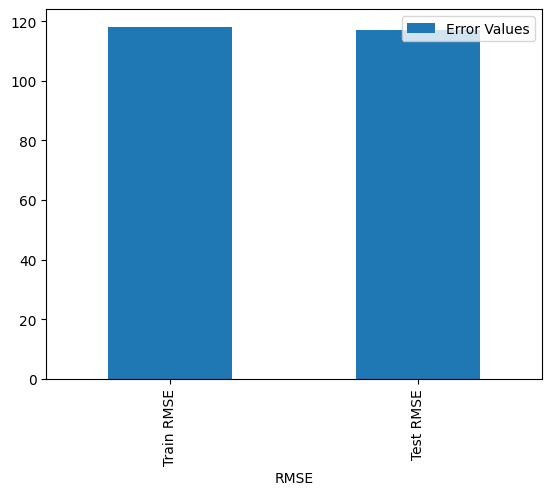

In [41]:
# Milestone 3: Bar plot with RMSE values, comparing train and test data
# To answer Question 4: "Where does your model fit in the fitting graph?"
df_barplot = pd.DataFrame({'RMSE': ['Train RMSE', 'Test RMSE'], 'Error Values': [118.133, 117.118]})  
df_barplot.plot.bar(x = 'RMSE', y = 'Error Values')  

<Axes: xlabel='R-Squared'>

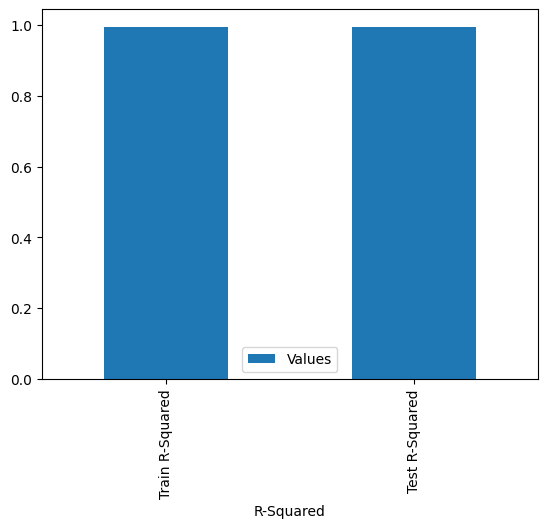

In [45]:
# Milestone 3: Bar plot with R-squared values, comparing train and test data
# To answer Question 4: "Where does your model fit in the fitting graph?"
df_barplot = pd.DataFrame({'R-Squared': ['Train R-Squared', 'Test R-Squared'], 'Values': [0.995, 0.995]})  
df_barplot.plot.bar(x = 'R-Squared', y = 'Values')  

### Scatterplots 

In [46]:
import matplotlib.pyplot as plt
changed_num_df = changed_df.sample(False, 0.1)
num_pdf = changed_num_df.toPandas()
print(num_pdf)

         basefloodelevation  basementenclosurecrawlspacetype   censustract  \
0                       NaN                              0.0  3.610316e+10   
1                       NaN                              0.0  6.077001e+09   
2                       NaN                              2.0  3.605941e+10   
3                       NaN                              1.0  3.301100e+10   
4                       6.0                              0.0  1.208601e+10   
...                     ...                              ...           ...   
5040966                 NaN                              0.0           NaN   
5040967                 NaN                              0.0  4.505105e+10   
5040968                 NaN                              3.0           NaN   
5040969                 9.0                              0.0  5.151020e+10   
5040970                 NaN                              0.0  2.203300e+10   

         countycode  crsdiscount  elevationdifference  federalp

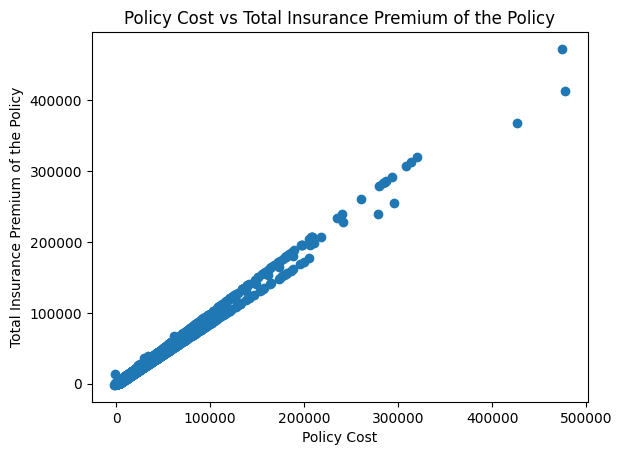

In [47]:
plt.scatter(x=num_pdf['policycost'],y=num_pdf['totalinsurancepremiumofthepolicy'])
plt.xlabel('Policy Cost')
plt.ylabel('Total Insurance Premium of the Policy')          
plt.title('Policy Cost vs Total Insurance Premium of the Policy')
plt.show()

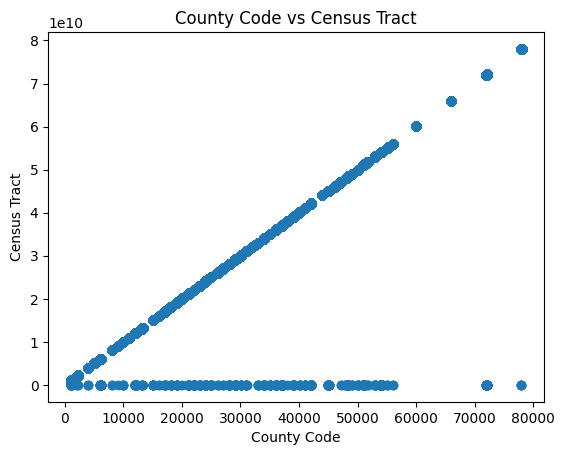

In [48]:
plt.scatter(x=num_pdf['countycode'],y=num_pdf['censustract'])
plt.xlabel('County Code')
plt.ylabel('Census Tract') 
plt.title('County Code vs Census Tract')
plt.show()

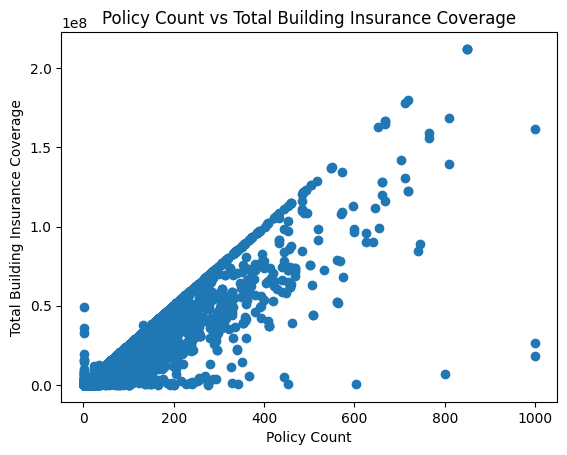

In [49]:
plt.scatter(x=num_pdf['policycount'],y=num_pdf['totalbuildinginsurancecoverage'])
plt.xlabel('Policy Count')
plt.ylabel('Total Building Insurance Coverage') 
plt.title('Policy Count vs Total Building Insurance Coverage')
plt.show()